In [1]:
#Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
from tqdm.notebook import trange, tqdm

In [2]:
batch_size = 64

lr = 1e-4

n_epoch = 10

latent_size = 128

dataset_folder = "../dataset"

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [3]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [4]:
class Encoder(nn.Module):
    def __init__(self, channels_in, ch, latent_size, class_size):
        super().__init__()
        self.lin1 = nn.Linear(channels_in + class_size, ch)
        # self.bn1 = nn.BatchNorm1d(ch)
        self.lin2 = nn.Linear(ch, ch)
        # self.bn2 = nn.BatchNorm1d(ch)
        self.f_mean = nn.Linear(ch, latent_size)
        self.f_logvar = nn.Linear(ch, latent_size)
        
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        mean = self.f_mean(x)
        logvar = self.f_logvar(x)
        
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, channels_out, ch, latent_size, class_size):
        super().__init__()
        self.lin1 = nn.Linear(latent_size + class_size, ch)
        # self.bn1 = nn.BatchNorm1d(ch)

        self.lin2 = nn.Linear(ch, ch)
        # self.bn2 = nn.BatchNorm1d(ch)

        self.output = nn.Linear(ch, channels_out)
    
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        return torch.tanh(self.output(x))


class VariationalAutoEncoder(nn.Module):
    def __init__(self, channels, ch, latent_size, class_size):
        super().__init__()
        self.encoder = Encoder(channels, ch, latent_size, class_size)
        self.decoder = Decoder(channels, ch, latent_size, class_size)

    def reparameterization(self, mean, var):
        epsilon = torch.rand_like(var).to(device)
        z = mean + var * epsilon
        
        return z

    def forward(self, x, label):
        mean, logvar = self.encoder(x.view(-1, 28*28), label)
        z = self.reparameterization(mean, torch.exp(0.5 * logvar))
        x = self.decoder(z, label)
        return x, mean, logvar

In [5]:
# MNIST dataset and dataloader
transform = transforms.Compose([
            transforms.ToTensor(),])

train_set = Datasets.MNIST(root=dataset_folder, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=dataset_folder, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

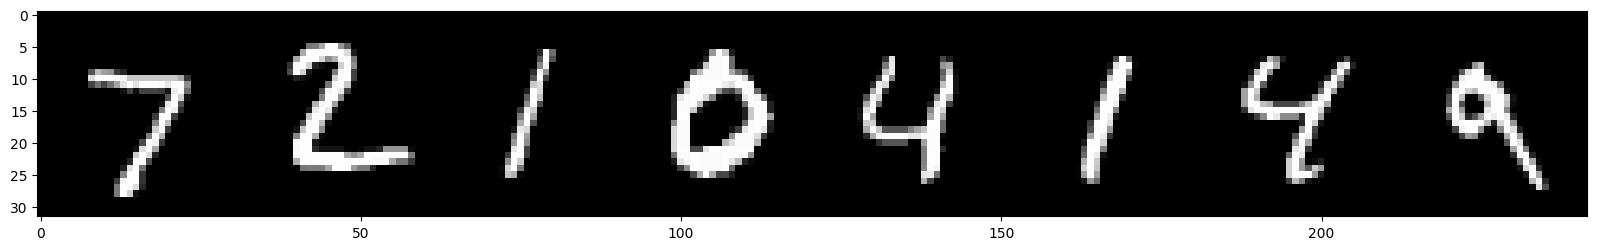

In [7]:
# Show data
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [8]:
# Create a Network

autoencoder = VariationalAutoEncoder(channels=28*28, ch=256, latent_size=latent_size, class_size=10).to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)


loss_log = []
train_loss = 0

In [9]:
def loss_func(recon_data, image, logvar, mu):
    # loss = nn.MSELoss(recon_data, image)
    loss = F.mse_loss(recon_data, image.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss + KLD

In [10]:
pbar = trange(0, n_epoch, leave=False, desc="Epoch")
for i in pbar:
    pbar.set_postfix_str("Loss: %.4f" % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        image = data[0].to(device)
        label = one_hot(data[1].to(device), 10)
        
        # random_sample = torch.bernoulli(0.7 * torch.ones_like(image)) - 0.5
        # noisy_img = random_sample * image
        
        # recon_data, mean, logvar = autoencoder(noisy_img, label)
        recon_data, mean, logvar = autoencoder(image, label)
        
        loss = loss_func(recon_data, image, logvar, mean)
        
        loss_log.append(loss.item())
        train_loss += loss.item()
        
        autoencoder.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

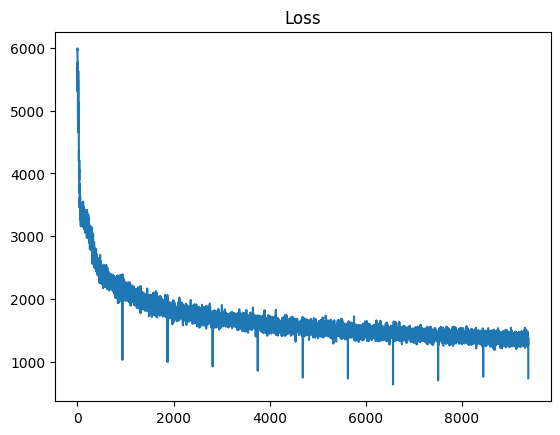

In [237]:
_ = plt.plot(loss_log)
_ = plt.title("Loss")

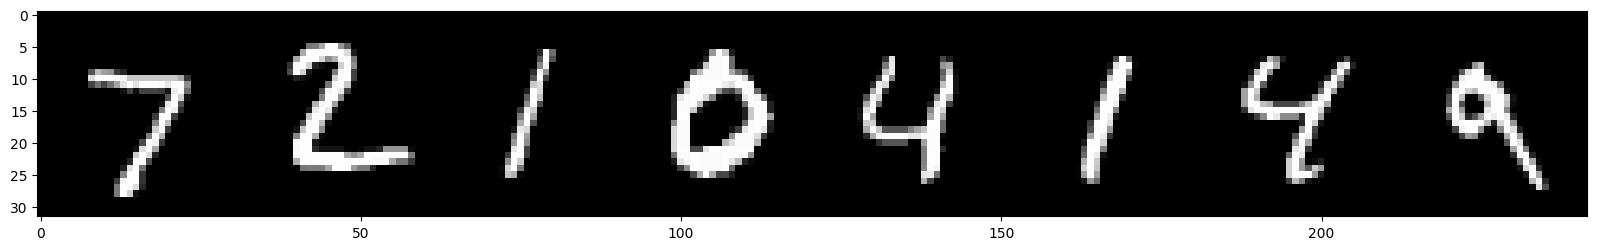

In [11]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# autoencoder = VariationalAutoEncoder(channels=1, ch=16, latent_size=128).to(device)

# optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

# autoencoder.load_state_dict(torch.load("./lab1.pth", weights_only=True))
# autoencoder.eval()

In [27]:
# plt.figure(figsize = (20,10))
noise = torch.rand((64, latent_size)).to(device)
# out = vutils.make_grid(noise.detach().cpu().view(64, 1, 28, 28)[0:8], normalize=True)
# _ = plt.imshow(out.numpy().transpose((1, 2, 0)))

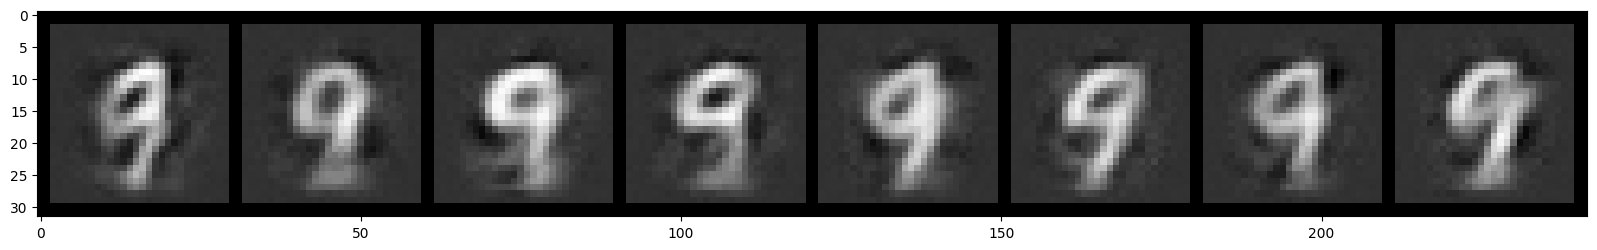

In [28]:
plt.figure(figsize = (20,10))
num = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).to(device)
inp = num.repeat(64, 1)
recon_data = autoencoder.decoder(noise, inp)
out = vutils.make_grid(recon_data.detach().cpu().view(64, 1, 28, 28)[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
torch.save(autoencoder.state_dict(), "./lab1.pth")